# First tries Deepfocus

In [40]:
%load_ext autoreload
%autoreload 2
# %load_ext tensorboard

import utils.model_utils as mut
import torch 
from torch import nn
# from torch.utils.tensorboard import SummaryWriter
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os 
# import wandb
from tqdm import tqdm
from astropy.io import fits

import myUtils
from models.blobsfinder import BlobsFinder
from models.deepgru import DeepGRU
from models.resnet import ResNet18
from models.resnet import ResBlock


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# As usual: loading the data

In [2]:
data_path = '/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync'
keys = np.load(os.path.join(data_path, "Sources_detection/sky_keys.npy"))
indices_train = np.load(os.path.join(data_path, "Sources_detection/seed_0/train_idx.npy"))
indices_validation = np.load(os.path.join(data_path, "Sources_detection/seed_0/validation_idx.npy"))
indices_test = np.load(os.path.join(data_path, "Sources_detection/seed_0/test_idx.npy"))

print("Numbber of keys: ", len(keys))
print("Lenght train set: ", len(indices_train))
print("Lenght validation set: ", len(indices_validation))
print("Lenght test set: ", len(indices_test))

Numbber of keys:  9164
Lenght train set:  7331
Lenght validation set:  917
Lenght test set:  916


In [3]:
# List of images paths regarding the train, validation and test set
train_images_path = [os.path.join(data_path, 'clean_gaussian', "clean_gaussians_" + keys[ind] + ".fits") for ind in indices_train]
validation_images_path = [os.path.join(data_path, 'clean_gaussian', "clean_gaussians_" + keys[ind] + ".fits") for ind in indices_validation]
test_images_path = [os.path.join(data_path, 'clean_gaussian', "clean_gaussians_" + keys[ind] + ".fits") for ind in indices_test]

print("Lenght train set: ", len(train_images_path))
print("Lenght validation set: ", len(validation_images_path))
print("Lenght test set: ", len(test_images_path))

Lenght train set:  7331
Lenght validation set:  917
Lenght test set:  916


In [4]:
train_RealDetection = myUtils.loadAllCatFile("/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync/Sources_detection/cat", "gaussians_", indices_train, keys)
validation_RealDetection = myUtils.loadAllCatFile("/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync/Sources_detection/cat", "gaussians_", indices_validation, keys)
test_RealDetection = myUtils.loadAllCatFile("/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync/Sources_detection/cat", "gaussians_", indices_test, keys)
print("Lenght train set: ", len(train_RealDetection))
print("Lenght validation set: ", len(validation_RealDetection))
print("Lenght test set: ", len(test_RealDetection))

# compute the pixels index of ground truth positions
train_RealDetection_px = [myUtils.RaDec2pixels(train_RealDetection[ind], fits.getheader(train_images_path[ind])) for ind in tqdm(range(len(train_RealDetection)))]
validation_RealDetection_px = [myUtils.RaDec2pixels(validation_RealDetection[ind], fits.getheader(validation_images_path[ind])) for ind in tqdm(range(len(validation_RealDetection)))]
test_RealDetection_px = [myUtils.RaDec2pixels(test_RealDetection[ind], fits.getheader(test_images_path[ind])) for ind in tqdm(range(len(test_RealDetection)))]

print()
print(torch.tensor(test_RealDetection_px[0]).shape)
print(torch.tensor(test_RealDetection_px[1]).shape)
print(torch.tensor(test_RealDetection_px[2]).shape)

Lenght train set:  7331
Lenght validation set:  917
Lenght test set:  916


100%|██████████| 916/916 [00:03<00:00, 251.72it/s]


torch.Size([2, 2])
torch.Size([2, 3])
torch.Size([2, 5])


## Creatiung the training input:
An input of our nn is simply the image contained in the fits file

100%|██████████| 916/916 [00:04<00:00, 204.43it/s]


shape train input:  torch.Size([7331, 512, 512])
shape validation input:  torch.Size([917, 512, 512])
shape test input:  torch.Size([916, 512, 512])


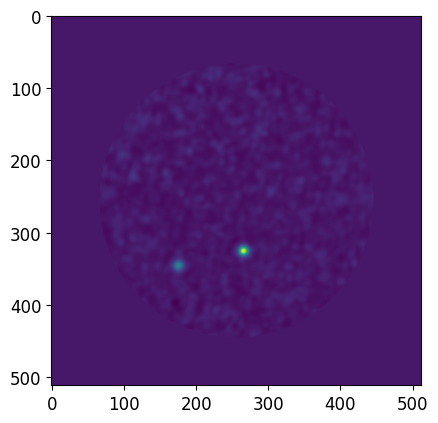

In [5]:
# open fits files from train_images_path and store them into a tensor train_input
train_input = [fits.getdata(train_images_path[ind])[0,0] for ind in tqdm(range(len(train_images_path)))]
train_input = torch.nan_to_num(torch.tensor(np.array(train_input)), nan=0)

# open fits files from validation_images_path and store them into a tensor validation_input
validation_input = [fits.getdata(validation_images_path[ind])[0,0] for ind in tqdm(range(len(validation_images_path)))]
validation_input = torch.nan_to_num(torch.tensor(np.array(validation_input)), nan=0)

# open fits files from test_images_path and store them into a tensor test_input
test_input = [fits.getdata(test_images_path[ind])[0,0] for ind in tqdm(range(len(test_images_path)))]
test_input = torch.nan_to_num(torch.tensor(np.array(test_input)), nan=0)

print("shape train input: ", train_input.shape)
print("shape validation input: ", validation_input.shape)
print("shape test input: ", test_input.shape)
plt.figure()
plt.imshow(train_input[0])
plt.show()

## Creating the target dataset
The target dataset is a zero image with 1 where there is a source. To create this tensor we use the list of real position of the source and set the pixels at this location to 1.

---- Important -----
We won't use my version bbecause I used only 1 pixel and so the size, and the shape of the source was forgotten and it was really hard to obtain good results. That's why I had to request the real binary maps (see below)

In [6]:
# torch.tensor(test_RealDetection_px[1]).shape

In [7]:
# test_RealDetection_px[1]

In [8]:
# train_target = torch.zeros(train_input.shape)
# for ind in tqdm(range(len(train_RealDetection_px))):
#     train_target[ind, train_RealDetection_px[ind][0,:], train_RealDetection_px[ind][1,:]] = 1

### Using the binary map given by olga



In [9]:
binaryMaps = np.load(os.path.join(data_path, "Sources_detection/sky_true_local_norm.npy"))
print("Binary map shape: ",binaryMaps.shape)


Binary map shape:  (9164, 512, 512)


In [10]:
train_binaryMaps = torch.tensor(binaryMaps[indices_train])
validation_binaryMaps = torch.tensor(binaryMaps[indices_validation])
test_binaryMaps = torch.tensor(binaryMaps[indices_test])

print("Lenght train binMap: ", train_binaryMaps.shape)
print("Lenght validation binMap: ", validation_binaryMaps.shape)
print("Lenght test binMap: ", test_binaryMaps.shape)

Lenght train binMap:  torch.Size([7331, 512, 512])
Lenght validation binMap:  torch.Size([917, 512, 512])
Lenght test binMap:  torch.Size([916, 512, 512])


# First NN test:
For this first test we train the model on the 916 test images just to see how it works. 

Note that I had to change some dimension size in the Deep focus source code: they had as input image of 256x256 and in our case, they are of size 512x512. So I had to change the "16" values at line 70, 93 and 96 in the blobfinder code with the value "32" which suits the desired size.


In [99]:
def trainingModel(input, target, device, criterion, epochs, batch_size, hidden_channels, lr_list, weight_decay=0, modelName='modeltmp', Training = True):
    lr_index = 0
    lr = lr_list[lr_index]

    model = ResBlock(1, 1, False)
    optimizer = torch.optim.SGD(model.parameters(), lr, weight_decay=weight_decay)

    if Training:
        print("Training..")
        
        model.to(device)
        input = input.to(device)
        target = target.to(device)

        lossHistory = []
        for e in range(epochs):
            # if e == 50:
            #     lr_index += 1
            #     lr = lr_list[lr_index]
            #     for g in optimizer.param_groups:
            #         g['lr'] = lr
            # if e == 100:
            #     lr_index += 1
            #     lr = lr_list[lr_index]
            #     for g in optimizer.param_groups:
            #         g['lr'] = lr

            acc_loss = 0
            for b in range(0, input.size(0), batch_size):    # using some mini batch 
                if b+batch_size <= input.shape[0]:                 # If the remaining dataset is large enough for a minibatch
                    print(input.shape)
                    print(input.narrow(0, b, batch_size).shape)
                    output = model(input.narrow(0, b, batch_size).unsqueeze(1))   # unsqueeze because we need data to have shape 64x1x512x512 and not 64x512x512
                    loss = criterion(output.squeeze(1), target.narrow(0, b, batch_size))
                else:               # Else we train on the remianing inputs
                    output = model(input.narrow(0, b, input.shape[0]-b).unsqueeze(1))   # unsqueeze because we need data to have shape 64x1x512x512 and not 64x512x512
                    loss = criterion(output.squeeze(1), target.narrow(0, b, input.shape[0]-b))
                
                acc_loss += loss.item()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            lossHistory.append(acc_loss)
            print(f"\tEpoch: {e+1}, loss ={acc_loss}")

        # --- Saving the model --- #     
        torch.save({
            'epoch': epochs,
            'batch_size': batch_size,
            'hidden_channels': hidden_channels,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss_history': lossHistory,
            }, './trainedModels/'+modelName+'_resnet'+'.pt'
        )
        return model, optimizer, epochs, batch_size, hidden_channels, lossHistory
    else:
        print("Testing...")

        loadedModel = torch.load('./trainedModels/'+modelName+'_resnet'+'.pt', map_location=torch.device('cpu'))
        epochs, batch_size, hidden_channels = loadedModel['epoch'], loadedModel['batch_size'], loadedModel['hidden_channels']
        model.load_state_dict(loadedModel['model_state_dict'])
        optimizer.load_state_dict(loadedModel['optimizer_state_dict'])
        lossHistory = loadedModel['train_loss_history']
    
        return model, optimizer, epochs, batch_size, hidden_channels, lossHistory


In [109]:
epochs = 200
batch_size = 64
muli_gpu = False
mode = 'train'
# learning_rate = 0.001
# learning_rate = 0.01
# weight_decay = 1e-5
weight_decay = 0
early_stopping = 'True'
patience = 20
hidden_channels = 64
warm_start=True
warm_start_iterations = 10
detection_threshold = 0.15

torch.manual_seed(42)


In [110]:
print("---"*15)
print()
print("Training..")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device: ", device)

lr = [0.001]
criterion = nn.L1Loss()
model, optimizer, epochs, batch_size, hidden_channels, lossHistory = trainingModel(train_input, train_binaryMaps, device, criterion, 
                                                    epochs, batch_size, hidden_channels, lr, modelName='model_test', Training=False)
# print()
model.eval()
print("batch size: ", batch_size)
print("Testing..")

with torch.no_grad():
    pred = model(test_input.unsqueeze(1))
    print("Testing loss: ", criterion(pred.squeeze(1), test_binaryMaps).item())
    print()

---------------------------------------------

Training..
device:  cpu
Testing...
batch size:  64
Testing..
Testing loss:  0.0006189317209646106



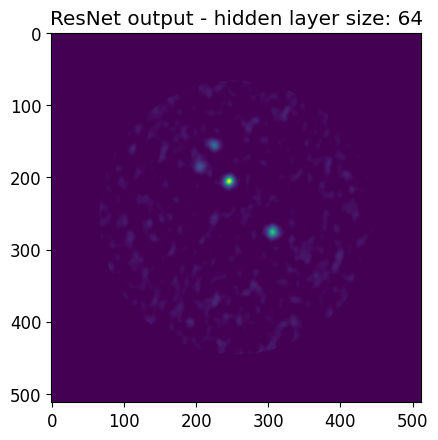

In [111]:
plt.figure()
plt.imshow(pred[2,0])
plt.title('ResNet output - hidden layer size: 64')
plt.show()

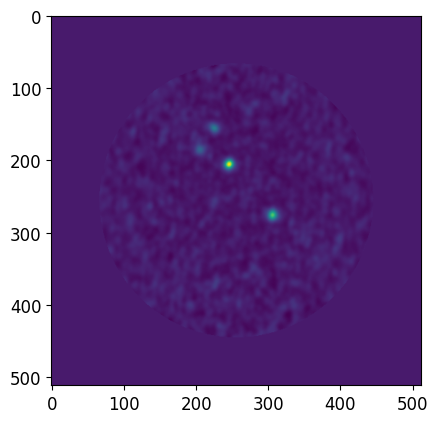

In [54]:
plt.imshow(test_input[2])

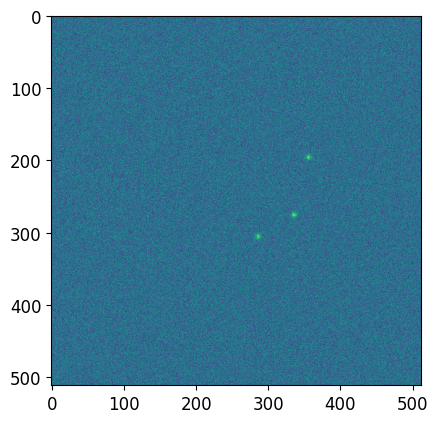

In [33]:
plt.imshow(test_binaryMaps[4]+np.random.normal(0,0.2,test_binaryMaps[4].shape))

In [29]:
np.random.normal(0,0.5,test_binaryMaps.shape).shape

(916, 512, 512)

In [16]:
with torch.no_grad():
    tmp = model(train_input[0].unsqueeze(0).unsqueeze(0))
    print(tmp.shape)


torch.Size([1, 1, 512, 512])


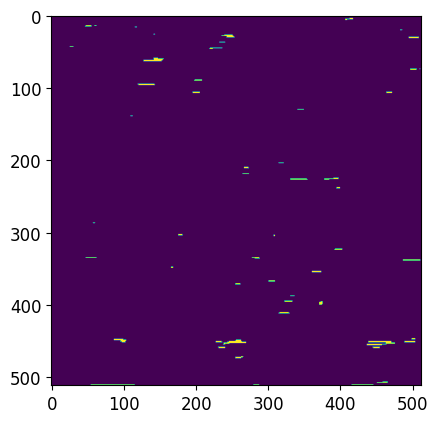

In [17]:
plt.imshow(tmp[0,0])

In [ ]:
wandb.login()
# Examples of single models training 
# ----------------------------------------------------------------
# wandb.init(project="DeepFocus", entity="patoch01220")

# wandb.config = {
#     "epochs" : 200,
#     "batch_size" : 64, 
#     "muli_gpu" : False, 
#     "mode" : 'train', 
#     "learning_rate" : 0.001,
#     "weight_decay" : 1e-5,
#     "early_stopping" : 'True',
#     "patience" : 20,
#     "hidden_channels" : 1024,
#     "criterion":['l_1', 'ssim'],
#     "warm_start":True,
#     "warm_start_iterations" : 10,
#     "detection_threshold" : 0.15,
#     "data_folder":'/lustre/home/mdelliveneri/ALMADL/data/',
#     "project" : 'ALMA',
#     "output_dir" : '/lustre/home/mdelliveneri/ALMADL/trained_models',
#     "prediction_dir" : '/lustre/home/mdelliveneri/ALMADL/predictions',
#     "plot_dir" : '/lustre/home/mdelliveneri/ALMADL/plots',
#     "model_name" : 'blobsfinder',
#     "experiment_name" : 'blobsfinder_test_01',
#     "entity" : 'mdelliveneri',
# } 

# Training Blobs Finder 
hyperparams = dict(
    epochs = 200,
    batch_size = 64, 
    muli_gpu = False, 
    mode = 'train', 
    learning_rate = 0.001,
    weight_decay = 1e-5,
    early_stopping = 'True',
    patience = 20,
    hidden_channels = 1024,
    criterion=['l_1', 'ssim'],
    warm_start=True,
    warm_start_iterations = 10,
    detection_threshold = 0.15,
    data_folder='/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/Dataset.nosync/clean_gaussian',
    project = 'DeepFocus',
    output_dir = '/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/DeepFocus/trainedModels',
    prediction_dir = '/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/DeepFocus/predictions',
    plot_dir = '/Users/patoch/Desktop/Patoch/Uni/2nd-Year/MasterThesis/master-thesis/DeepFocus/plots',
    model_name = 'blobsfinder',
    experiment_name = 'blobsfinder_test_01',
    entity = 'mdelliveneri',
)
with wandb.init(project=hyperparams['project'], name=hyperparams['experiment_name'], entity=hyperparams['entity'], config=hyperparams):
    config = wandb.config
    blobsfinder, criterion, optimizer, train_loader, valid_loader = mut.make_blobsfinder(config, device)
    mut.train(blobsfinder, criterion, optimizer, train_loader, valid_loader)

